In [7]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual

import os

## Read the dataset

In [8]:
from dataloaders.germany_dataset import load_image_and_labels
from image_helpers import polygons_to_bounding_boxes, polygons_to_masks, mask_to_polygons
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.tv_tensors import BoundingBoxes, Mask

In [10]:
def plot_image_and_mask(image, masks, ax=None):
    # Convert images to uint8
    image = (image * 255).byte()
    
    # Convert masks to bool
    masks = masks.bool()
    
    # Draw the masks on the image
    image_with_masks = draw_segmentation_masks(image, masks)
    
    # Convert to PIL image
    image_with_masks = image_with_masks.permute(1, 2, 0).numpy()
    
    if ax is None:
        plt.imshow(image_with_masks)
        plt.axis('off')
    else:
        ax.imshow(image_with_masks)
        
    

In [11]:
from dataloaders.solar_dk_dataset import SolarDKDataset
import torchvision.transforms.v2 as transforms

train_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/train"
validation_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/val"

train_dataset = SolarDKDataset(train_folder)
validation_dataset = SolarDKDataset(validation_folder)

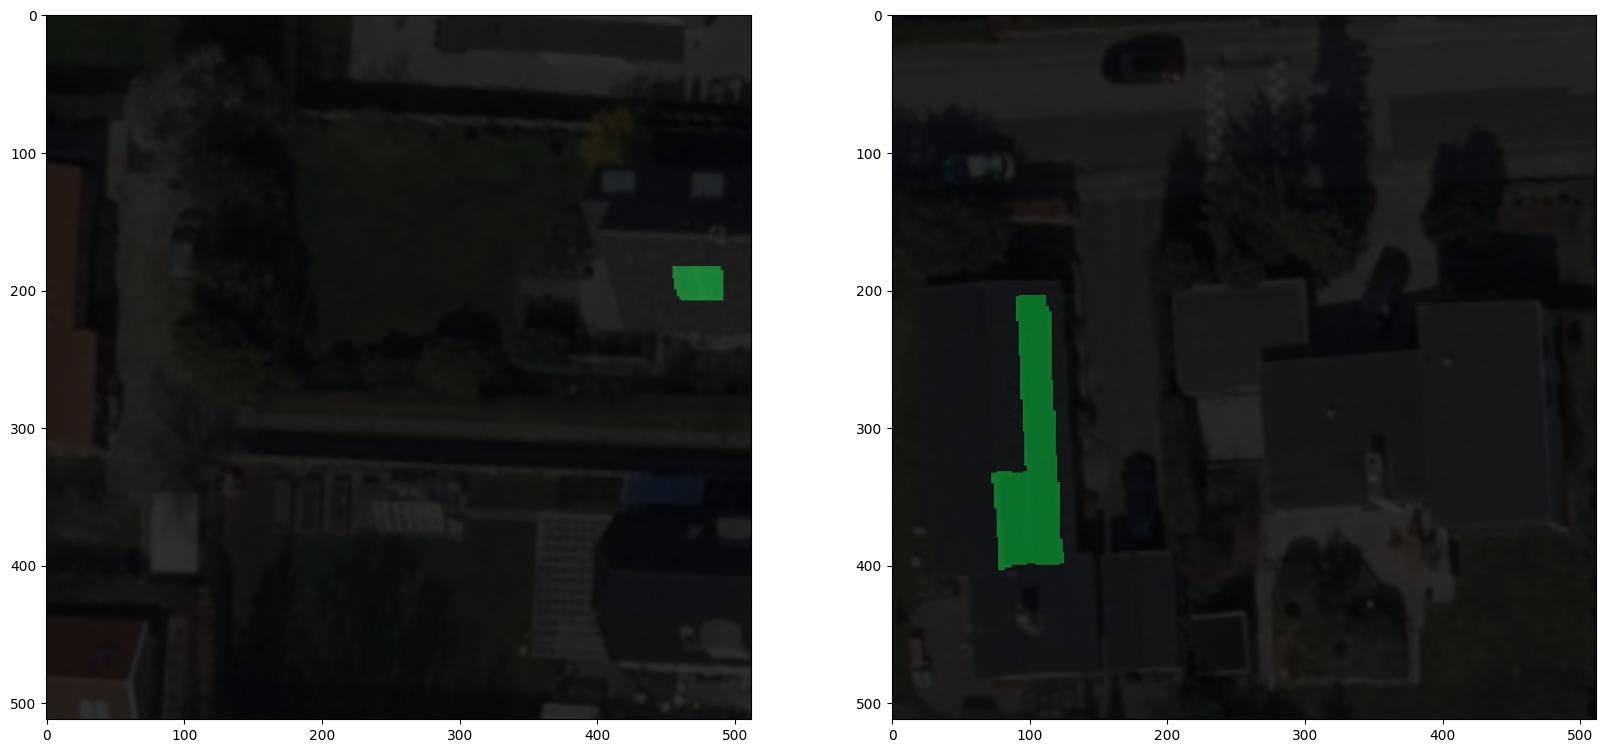

In [19]:
# Convert mean and std to tensors
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

mean_tensor = torch.tensor(mean).view(1, 3, 1, 1)
std_tensor = torch.tensor(std).view(1, 3, 1, 1)

inv_transform = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
    transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[ 1., 1., 1.]),
])

fig, ax = plt.subplots(2, 2, figsize=(20, 10))
plot_image_and_mask(inv_transform(train_dataset[0][0]), train_dataset[0][1], ax=ax[0])
plot_image_and_mask(inv_transform(train_dataset[1][0]), train_dataset[1][1], ax=ax[1])


### Load the dataset

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_dataset = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=4)

### Train the model

In [13]:
import pytorch_lightning as pl
from models.base import BaseModel
from models.architectures.deep_lab import DeepLabModel
# from models.architectures.mask_rcnn import MaskRCNNModel
from models.architectures.unet import UNetModel

In [ ]:
for image, label in train_dataloader:
    # Print the size of the image and label
    print(image.size(), label.size())  
    break

torch.Size([4, 3, 512, 512]) torch.Size([4, 2, 512, 512])


In [14]:
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss
from torch import nn

class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss(mode="multiclass")
        self.jaccard_loss = JaccardLoss(mode="multiclass")

    def forward(self, y_pred, y_true):
        cross_entropy_loss = self.cross_entropy(y_pred, y_true)
        dice_loss = self.dice_loss(y_pred, y_true)
        jaccard_loss = self.jaccard_loss(y_pred, y_true)

        return cross_entropy_loss + 2 * dice_loss + 3 * jaccard_loss

/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.


tensor(2)
Dice Score: 0.0
Jaccard Index: 0.4872570037841797
Accuracy: 0.9745140075683594
Precision: 0.9745140075683594
Recall: 0.9745140075683594
F1 Score: 0.9745140075683594


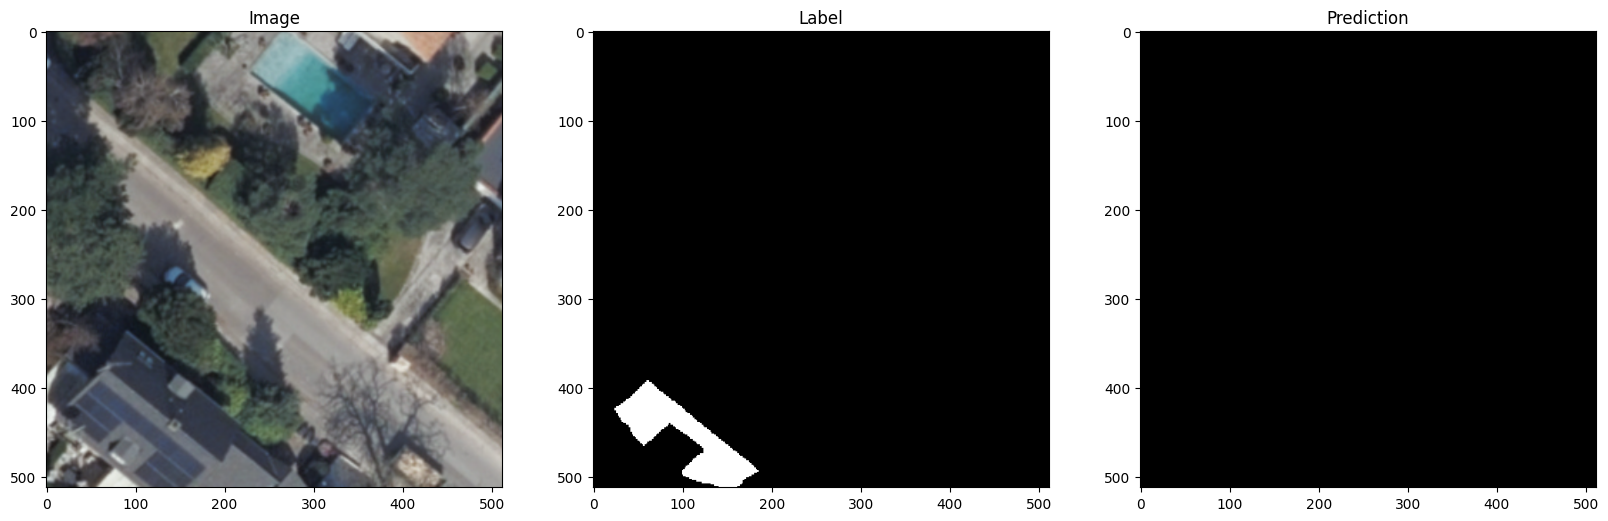

In [18]:
import torch
from models.base import BaseModel

from torchmetrics.functional import jaccard_index, accuracy, precision, recall, f1_score, dice

test_folder = "data/solardk_dataset_neurips_v2/herlev_test/test"

model = BaseModel.load_from_checkpoint("lightning_logs/version_206484/checkpoints/last.ckpt")

test_dataset = SolarDKDataset(test_folder)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

task = "multiclass"
num_classes = 2

# Loop on train dataloader until mask is not just zeros
for image, label in train_dataloader:
    # Check if the second channel of any of the batches is not all zeros
    if (label[:, 1] != 0).any():
        id = (label[:, 1] != 0).nonzero(as_tuple=True)[0][0]
        print(id)
        break
        
# Estimate the model on the test set

model.eval()
with torch.no_grad():
    output = model(image)
    
    image = image[id]
    label = label[id]
    output = output[id]
    
    image = inv_transform(image)
    output_predictions = output.argmax(dim=0).float().squeeze()
    label = label.argmax(dim=0).float().squeeze()
              
    print(f"Dice Score: {dice(output_predictions, label.int())}")
    print(f"Jaccard Index: {jaccard_index(output_predictions, label, task=task, num_classes=num_classes)}")
    print(f"Accuracy: {accuracy(output_predictions, label, task=task, num_classes=num_classes)}")
    print(f"Precision: {precision(output_predictions, label, task=task, num_classes=  num_classes)}")
    print(f"Recall: {recall(output_predictions, label, task=task, num_classes=num_classes)}")
    print(f"F1 Score: {f1_score(output_predictions, label, task=task, num_classes=num_classes)}")
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("Image")
    
    ax[1].imshow(label, cmap="gray")
    ax[1].set_title("Label")     
    
    ax[2].imshow(output_predictions, cmap="gray")
    ax[2].set_title("Prediction")
    